Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1996082..2.1376178].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1945262..2.04145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0391905..2.0971737].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4237949..2.1177425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2822855..2.0009627].


Input shape: torch.Size([32, 3, 32, 32])
Noisy shape: torch.Size([32, 3, 32, 32])


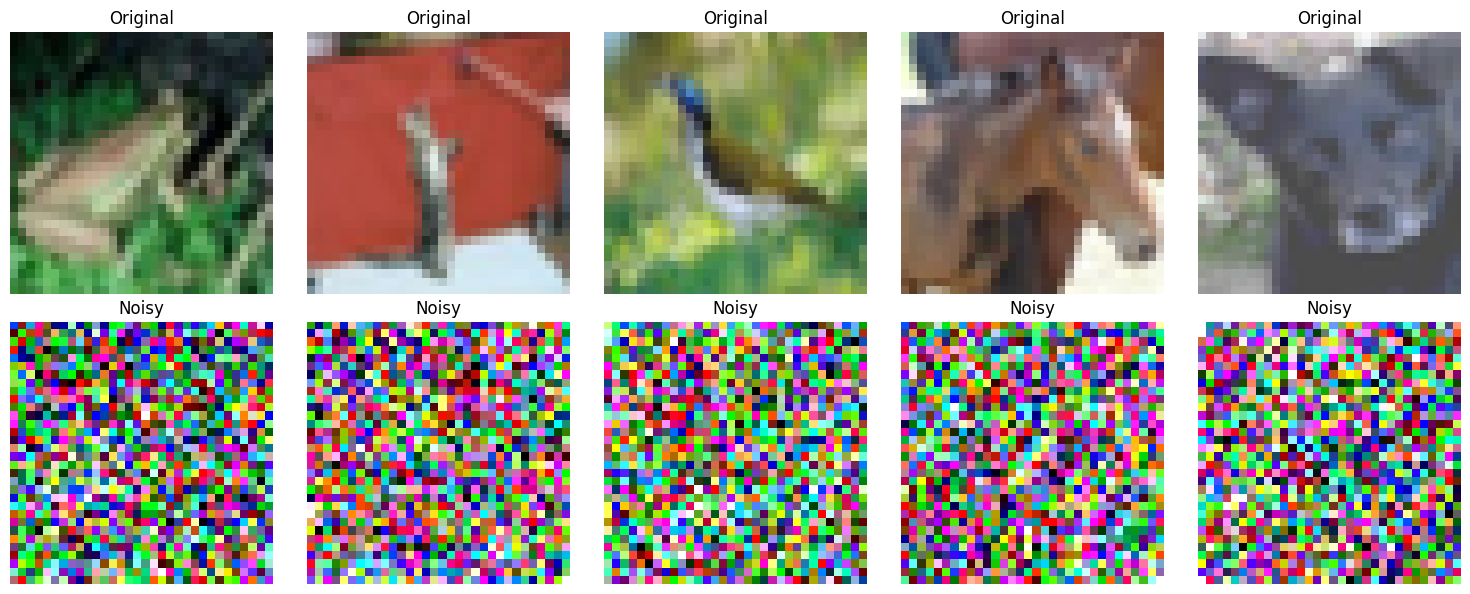

In [2]:
import torch
from utils.gaussian_diffusion import GaussianDiffusion
import torchvision
import torchvision.transforms as transforms

from utils.visualization import visualize_noisy_samples, visualize_image_with_patch_entropy, visualize_image_with_patches

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

diffusion = GaussianDiffusion(img_size=(3, 32, 32), timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu')

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = torch.randint(0, diffusion.timesteps, (images.size(0),), device='cpu').long()
x_t, noise = diffusion.forward_diffusion(images, t)

print(f"Input shape: {images.shape}")
print(f"Noisy shape: {x_t.shape}")

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')

t = 500
noisy_images, noise = diffusion.forward_diffusion(images, t)

visualize_noisy_samples(images, noisy_images, num_samples=5)

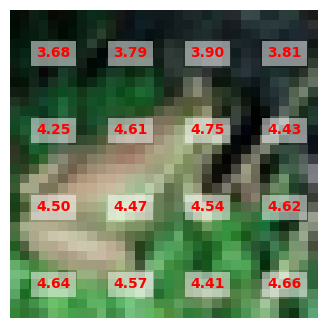

In [5]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
import numpy as np

def calculate_local_entropy(image, patch_size=8):
    """
    Calculate local entropy for non-overlapping patches of an image.
    
    Args:
        image (torch.Tensor): A single image tensor of shape (C, H, W).
        patch_size (int): Size of the square patches to extract.
    
    Returns:
        entropy_map (np.ndarray): A 2D array containing entropy values for each patch.
    """
    image = image.cpu().numpy()
    
    C, H, W = image.shape
    
    num_patches_x = H // patch_size
    num_patches_y = W // patch_size
    
    entropy_map = np.zeros((num_patches_x, num_patches_y))

    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            
            patch_data = patch.flatten()
            patch_data = (patch_data - patch_data.min()) / (patch_data.max() - patch_data.min())
            
            hist, _ = np.histogram(patch_data, bins=256, range=(0, 1), density=True)
            
            patch_entropy = entropy(hist + 1e-10)  # Add a small constant to avoid log(0)
            
            entropy_map[i, j] = patch_entropy
    
    return entropy_map

single_image = images[0]

patch_size = 8
entropy_map = calculate_local_entropy(single_image, patch_size=patch_size)

visualize_image_with_patch_entropy(single_image, entropy_map, patch_size=patch_size)

In [6]:
import math

def calculate_timesteps(max_timesteps, normalized_randomness):
    return int((max_timesteps-1) / math.exp(normalized_randomness))

def apply_noise_based_on_randomness(image, diffusion, randomness_map, patch_size=8, max_timesteps=1000):
    noisy_image = image.clone()

    num_patches_x, num_patches_y = randomness_map.shape

    min_randomness = randomness_map.min()
    max_randomness = randomness_map.max()
    if max_randomness - min_randomness == 0:
        normalized_randomness = 1
    else:
        normalized_randomness = (randomness_map - min_randomness) / (max_randomness - min_randomness)

    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

            # timesteps = int((1 - normalized_randomness[i, j]) * max_timesteps)
            # timesteps = int((max_timesteps-1)/math.exp(normalized_randomness[i, j]))
            timesteps = calculate_timesteps(max_timesteps, normalized_randomness[i, j])
            # print(f"For ra {normalized_randomness[i, j]} noising with {timesteps} timesteps")

            t = torch.tensor([timesteps], device=image.device)
            noisy_patch, _ = diffusion.forward_diffusion(patch.unsqueeze(0), t)

            noisy_image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = noisy_patch.squeeze(0)

    return noisy_image

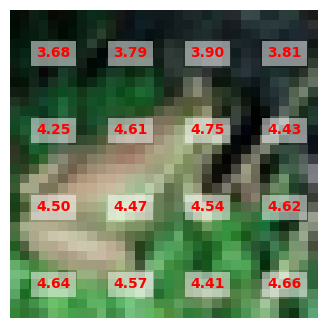

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3547785..1.6465718].


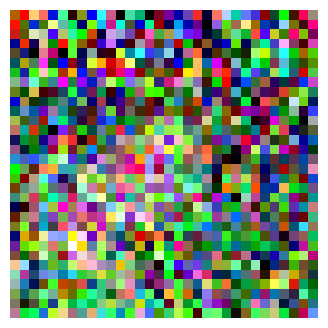

In [8]:
patch_size = 8
randomness_map = calculate_local_entropy(single_image, patch_size=patch_size)

max_timesteps = 500
noisy_image = apply_noise_based_on_randomness(single_image, diffusion, randomness_map, patch_size=patch_size, max_timesteps=max_timesteps)

visualize_image_with_patch_entropy(single_image, entropy_map, patch_size=patch_size)
visualize_image_with_patches(noisy_image, patch_size=patch_size, show_borders=False)

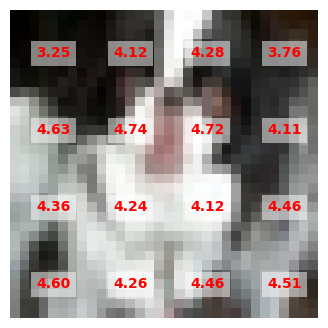

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9261607..1.9223926].


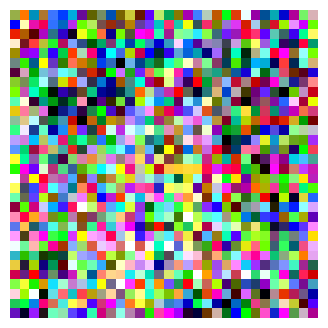

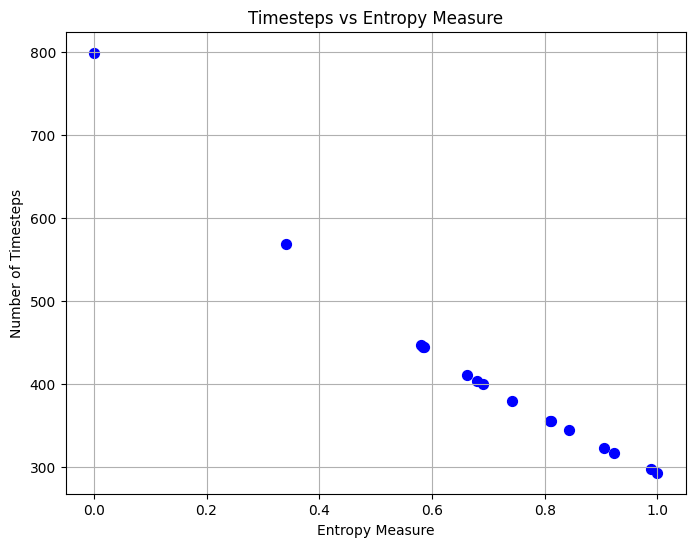

In [9]:
import matplotlib.pyplot as plt

ra_timesteps_data = []

def process_and_visualize_image(image, diffusion, patch_size=8, max_timesteps=1000):
    global ra_timesteps_data

    randomness_map = calculate_local_entropy(image, patch_size=patch_size)
    noisy_image = apply_noise_based_on_randomness(image, diffusion, randomness_map, patch_size=patch_size, max_timesteps=max_timesteps)

    for i in range(randomness_map.shape[0]):
        for j in range(randomness_map.shape[1]):
            num_patches_x, num_patches_y = randomness_map.shape

            min_randomness = randomness_map.min()
            max_randomness = randomness_map.max()
            if max_randomness - min_randomness == 0:
                normalized_randomness = 1
            else:
                normalized_randomness = (randomness_map - min_randomness) / (max_randomness - min_randomness)

            ra_value = normalized_randomness[i, j].item()
            timesteps = calculate_timesteps(max_timesteps, normalized_randomness[i, j])
            ra_timesteps_data.append((ra_value, timesteps))

    visualize_image_with_patch_entropy(image, randomness_map, patch_size=patch_size)
    visualize_image_with_patches(noisy_image, patch_size=patch_size, show_borders=False)

def plot_all_timesteps_vs_randomness():
    ra_values, timestep_values = zip(*ra_timesteps_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(ra_values, timestep_values, color='blue', s=50)
    plt.title("Timesteps vs Entropy Measure")
    plt.xlabel("Entropy Measure")
    plt.ylabel("Number of Timesteps")
    plt.grid(True)
    plt.show()

data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.to('cpu')


process_and_visualize_image(images[0], diffusion, patch_size=8, max_timesteps=800)
plot_all_timesteps_vs_randomness()